# Ensemble Revenue Forecasting - Test Notebook

This notebook tests the ensemble pipeline for 12-month revenue forecasting.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

from model.pipeline import EnsemblePipeline
from model.data_loader import DataLoader


## 1. Load and Inspect Data


In [2]:
# Load and inspect data_template.csv
csv_path = '../data_template.csv'

print("Inspecting data_template.csv structure...")
print("="*70)

# First, let's see the raw structure
import pandas as pd
raw_data = pd.read_csv(csv_path, comment='#', nrows=20)  # Read first 20 rows, skip comments
print(f"\nData shape: {raw_data.shape}")
print(f"\nColumns (in order): {list(raw_data.columns)}")
print(f"\nFirst few rows:")
print(raw_data.head(10).to_string())

print(f"\n\nData types:")
print(raw_data.dtypes)

print(f"\n\nMissing values per column:")
print(raw_data.isnull().sum())

print(f"\n\nStage distribution:")
print(raw_data['current_stage'].value_counts())

# Now try loading with DataLoader
data_loader = DataLoader(min_years=1.0)

try:
    data = data_loader.load_csv(csv_path)
    print("\n" + "="*70)
    print("Data loaded successfully with DataLoader!")
    print("="*70)
    
    # Display metadata
    metadata = data_loader.get_metadata()
    print(f"\nMetadata:")
    for key, value in metadata.items():
        if isinstance(value, pd.Timestamp):
            print(f"  {key}: {value.date()}")
        else:
            print(f"  {key}: {value}")
        
except ValueError as e:
    print("\n" + "="*70)
    print(f"Validation Error: {e}")
    print("="*70)
    print("\nNote: data_template.csv has limited data (only 10 records).")
    print("It spans less than 1 year, so it won't pass validation.")
    print("We'll generate synthetic data with sufficient history for testing.")


Inspecting data_template.csv structure...

Data shape: (10, 12)

Columns (in order): ['lead_id', 'inquiry_date', 'destination', 'trip_price', 'lead_source', 'current_stage', 'is_repeat_customer', 'quote_date', 'booking_date', 'trip_date', 'final_payment_date', 'duration_days']

First few rows:
     lead_id inquiry_date    destination  trip_price   lead_source current_stage  is_repeat_customer  quote_date booking_date   trip_date final_payment_date  duration_days
0  LEAD_0001   2023-01-15         Europe        4500      Referral     completed                   0  2023-01-18   2023-02-01  2023-07-15         2023-06-15             14
1  LEAD_0002   2023-01-18           Asia        5200       Website          lost                   0  2023-01-22          NaN         NaN                NaN             10
2  LEAD_0003   2023-01-22  Latin America        3800        Repeat     completed                   1  2023-01-24   2023-02-05  2023-08-10         2023-07-10             10
3  LEAD_0004   20

## 2. Generate Synthetic Data (if needed)

If your data_template.csv doesn't have enough historical data, we can generate synthetic data for testing.


In [ ]:
# Generate synthetic data matching data_template.csv structure
from datetime import datetime, timedelta
import random

def generate_test_data(n_records=500, start_date='2022-01-01', end_date='2024-12-31', active_lead_pct=0.25):
    """
    Generate synthetic travel booking data matching data_template.csv structure.
    
    Column order matches template:
    lead_id, inquiry_date, destination, trip_price, lead_source, current_stage,
    is_repeat_customer, quote_date, booking_date, trip_date, final_payment_date, duration_days
    
    Parameters:
    - n_records: Total number of records to generate
    - start_date: Start date for historical data
    - end_date: End date (used as "today" for active leads)
    - active_lead_pct: Percentage of leads that should be active (default 25%)
    """
    
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    today = end  # Use end_date as "today" for determining active leads
    
    data = []
    n_active = int(n_records * active_lead_pct)
    
    for i in range(n_records):
        # Determine if this should be an active lead
        is_active = (i < n_active)
        
        if is_active:
            # Active leads: recent inquiry dates (within last 6 months)
            days_back = random.randint(0, 180)
            inquiry_date = today - timedelta(days=days_back)
        else:
            # Historical leads: spread across entire date range
            inquiry_date = start + timedelta(days=random.randint(0, (end - start).days))
        
        # Destination and characteristics (matching template values)
        destination = random.choice(['Latin America', 'Europe', 'Asia'])
        lead_source = random.choice(['Referral', 'Website', 'Repeat', 'Social Media'])
        duration = random.choice([7, 10, 14, 21])
        
        # Base price (matching template ranges)
        base_prices = {'Latin America': 3500, 'Europe': 4500, 'Asia': 5000}
        base_price = base_prices[destination]
        trip_price = base_price + (duration - 7) * 200 + random.gauss(0, 500)
        trip_price = max(2000, trip_price)
        
        is_repeat = 1 if lead_source == 'Repeat' else int(np.random.choice([0, 1], p=[0.8, 0.2]))
        
        # Initialize date fields as empty strings (matching template format)
        quote_date = ''
        booking_date = ''
        trip_date = ''
        final_payment_date = ''
        
        if is_active:
            # Active lead: assign to one of the active stages
            stage_roll = random.random()
            if stage_roll < 0.25:
                # inquiry stage: just inquired, no dates filled
                current_stage = 'inquiry'
            elif stage_roll < 0.50:
                # quote_sent: quote sent, waiting for response
                current_stage = 'quote_sent'
                quote_date = inquiry_date + timedelta(days=random.randint(1, 7))
            elif stage_roll < 0.75:
                # booked: booked but trip hasn't happened yet
                current_stage = 'booked'
                quote_date = inquiry_date + timedelta(days=random.randint(1, 7))
                booking_date = quote_date + timedelta(days=random.randint(5, 30))
                # Trip date in the future (30-180 days from booking)
                trip_date = booking_date + timedelta(days=random.randint(30, 180))
            else:
                # final_payment: final payment made, trip upcoming
                current_stage = 'final_payment'
                quote_date = inquiry_date + timedelta(days=random.randint(1, 7))
                booking_date = quote_date + timedelta(days=random.randint(5, 30))
                trip_date = booking_date + timedelta(days=random.randint(30, 180))
                final_payment_date = trip_date - timedelta(days=random.randint(7, 30))
        else:
            # Historical lead: normal conversion logic
            base_conversion = 0.35
            if is_repeat:
                base_conversion += 0.25
            if lead_source == 'Referral':
                base_conversion += 0.15
            
            base_conversion = min(base_conversion, 0.85)
            
            # Quote sent
            if random.random() < 0.85:
                quote_date = inquiry_date + timedelta(days=random.randint(1, 10))
                
                # Booking
                if random.random() < base_conversion:
                    lead_time_days = random.randint(30, 180)
                    booking_date = quote_date + timedelta(days=random.randint(5, 45))
                    trip_date = booking_date + timedelta(days=lead_time_days)
                    final_payment_date = trip_date - timedelta(days=random.randint(30, 45))
                    
                    if random.random() < 0.05:
                        current_stage = 'cancelled'
                        trip_price = 0
                    else:
                        current_stage = 'completed'
                else:
                    current_stage = 'lost'
                    trip_price = 0
                    # Keep dates as empty strings for lost leads
            else:
                current_stage = 'lost'
                trip_price = 0
                # Keep dates as empty strings
        
        # Format dates as strings (YYYY-MM-DD) or empty string
        def format_date(dt):
            if dt == '' or dt is None:
                return ''
            return dt.strftime('%Y-%m-%d') if isinstance(dt, (datetime, pd.Timestamp)) else dt
        
        data.append({
            'lead_id': f'LEAD_{i:04d}',
            'inquiry_date': inquiry_date.strftime('%Y-%m-%d'),
            'destination': destination,
            'trip_price': trip_price,
            'lead_source': lead_source,
            'current_stage': current_stage,
            'is_repeat_customer': is_repeat,
            'quote_date': format_date(quote_date),
            'booking_date': format_date(booking_date),
            'trip_date': format_date(trip_date),
            'final_payment_date': format_date(final_payment_date),
            'duration_days': duration
        })
    
    # Create DataFrame with exact column order matching template
    column_order = [
        'lead_id', 'inquiry_date', 'destination', 'trip_price', 'lead_source', 
        'current_stage', 'is_repeat_customer', 'quote_date', 'booking_date', 
        'trip_date', 'final_payment_date', 'duration_days'
    ]
    df = pd.DataFrame(data)
    df = df[column_order]  # Ensure correct column order
    
    return df

# Generate test data with active leads
# Using current date as end_date so active leads are truly "active"
from datetime import datetime
today = datetime.now().strftime('%Y-%m-%d')

print("Generating synthetic test data matching data_template.csv structure...")
print("="*70)
print(f"Using '{today}' as 'today' for active leads")
test_data = generate_test_data(n_records=500, start_date='2022-01-01', end_date=today, active_lead_pct=0.25)

# Save to CSV (without index, matching template format)
# Save to data/ directory
import os
data_dir = '../data'
os.makedirs(data_dir, exist_ok=True)
test_csv_path = os.path.join(data_dir, 'test_data.csv')
test_data.to_csv(test_csv_path, index=False)
print(f"\n✓ Test data saved to {test_csv_path}")

print(f"\nData summary:")
print(f"  Total records: {len(test_data)}")
print(f"  Completed trips: {len(test_data[test_data['current_stage'] == 'completed'])}")
print(f"  Lost leads: {len(test_data[test_data['current_stage'] == 'lost'])}")
print(f"  Cancelled: {len(test_data[test_data['current_stage'] == 'cancelled'])}")

# Active pipeline breakdown
active = test_data[test_data['current_stage'].isin(['inquiry', 'quote_sent', 'booked', 'final_payment'])]
print(f"\n  Active pipeline: {len(active)} leads")
if len(active) > 0:
    print(f"    - inquiry: {len(active[active['current_stage'] == 'inquiry'])}")
    print(f"    - quote_sent: {len(active[active['current_stage'] == 'quote_sent'])}")
    print(f"    - booked: {len(active[active['current_stage'] == 'booked'])}")
    print(f"    - final_payment: {len(active[active['current_stage'] == 'final_payment'])}")
    active_revenue = active['trip_price'].sum()
    print(f"    - Total pipeline value: ${active_revenue:,.0f}")

# Show date ranges
completed = test_data[test_data['current_stage'] == 'completed']
if not completed.empty:
    completed['trip_date_dt'] = pd.to_datetime(completed['trip_date'])
    print(f"\n  Completed trip date range: {completed['trip_date_dt'].min().date()} to {completed['trip_date_dt'].max().date()}")
    date_range_years = (completed['trip_date_dt'].max() - completed['trip_date_dt'].min()).days / 365.25
    print(f"  Historical date span: {date_range_years:.2f} years")

# Show active lead date ranges
if len(active) > 0:
    active['inquiry_date_dt'] = pd.to_datetime(active['inquiry_date'])
    print(f"\n  Active leads inquiry date range: {active['inquiry_date_dt'].min().date()} to {active['inquiry_date_dt'].max().date()}")

print(f"\n  Column order matches template: {list(test_data.columns) == ['lead_id', 'inquiry_date', 'destination', 'trip_price', 'lead_source', 'current_stage', 'is_repeat_customer', 'quote_date', 'booking_date', 'trip_date', 'final_payment_date', 'duration_days']}")


Generating synthetic test data matching data_template.csv structure...
Using '2025-11-20' as 'today' for active leads

✓ Test data saved to test_data.csv

Data summary:
  Total records: 500
  Completed trips: 148
  Lost leads: 221
  Cancelled: 6

  Active pipeline: 125 leads
    - inquiry: 25
    - quote_sent: 39
    - booked: 33
    - final_payment: 28
    - Total pipeline value: $698,918

  Completed trip date range: 2022-04-19 to 2026-04-03
  Historical date span: 3.96 years

  Active leads inquiry date range: 2025-05-24 to 2025-11-20

  Column order matches template: True


In [ ]:
# Initialize pipeline
pipeline = EnsemblePipeline(model_dir="model/artifacts", min_years=1.0)

# Train models
# Use test_data.csv if you generated it, otherwise use your actual data
test_data_path = '../data/test_data.csv'
training_csv = test_data_path if os.path.exists(test_data_path) else csv_path

try:
    training_metadata = pipeline.train(training_csv)
    print("\nTraining completed successfully!")
    print("\nTraining metadata:")
    for model, metadata in training_metadata.items():
        print(f"\n{model.upper()}:")
        for key, value in metadata.items():
            print(f"  {key}: {value}")
except Exception as e:
    print(f"\nTraining error: {e}")
    import traceback
    traceback.print_exc()


14:50:09 - cmdstanpy - INFO - Chain [1] start processing


Saving models to: ./model/artifacts
ENSEMBLE PIPELINE - TRAINING

Loading data from test_data.csv...

Data Summary:
  Total records: 500
  Completed trips: 148
  Total revenue: $817,759
  Date range: 3.96 years
  Conversion rate: 29.6%

Preparing monthly revenue time series...
  Monthly data points: 49
TRAINING ENSEMBLE MODELS
Training Prophet model...


14:50:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:50:09 - cmdstanpy - INFO - Chain [1] start processing
14:50:09 - cmdstanpy - INFO - Chain [1] done processing
14:50:09 - cmdstanpy - INFO - Chain [1] start processing
14:50:09 - cmdstanpy - INFO - Chain [1] done processing
14:50:09 - cmdstanpy - INFO - Chain [1] start processing
14:50:10 - cmdstanpy - INFO - Chain [1] done processing
14:50:10 - cmdstanpy - INFO - Chain [1] start processing
14:50:10 - cmdstanpy - INFO - Chain [1] done processing
14:50:10 - cmdstanpy - INFO - Chain [1] start processing
14:50:10 - cmdstanpy - INFO - Chain [1] done processing
14:50:10 - cmdstanpy - INFO - Chain [1] start processing
14:50:10 - cmdstanpy - INFO - Chain [1] done processing
14:50:10 - cmdstanpy - INFO - Chain [1] start processing
14:50:11 - cmdstanpy - INFO - Chain [1] done processing
14:50:11 - cmdstanpy - INFO - Chain [1] start pro


⚠ Could not perform Prophet cross-validation: 'mape'
   (This is okay - model is still trained)

Prophet model trained and saved to ./model/artifacts/prophet_model.pkl
Training XGBoost model...
Note: Using XGBoost fit() without early_stopping_rounds (version compatibility)

XGBOOST MODEL PERFORMANCE METRICS

Test Set Performance:
  Accuracy:  0.627 (62.7%)
  ROC-AUC:   0.641
  Precision: 0.542
  Recall:    0.433
  F1-Score:  0.481

Training Set Performance (for comparison):
  Accuracy:  0.823 (82.3%)
  ROC-AUC:   0.898

Confusion Matrix:
  True Negatives:  34
  False Positives: 11
  False Negatives: 17
  True Positives:  13

XGBoost model saved to ./model/artifacts/xgboost_model.json

TRAINING COMPLETE

TRAINING METRICS SUMMARY

Prophet Model:
  Status: ✓ Trained
  Training samples: 49

XGBoost Model:
  Status: ✓ Trained
  Training samples: 300
  Test samples: 75
  Test Accuracy:  0.627 (62.7%)
  Test ROC-AUC:   0.641
  Test Precision: 0.542
  Test Recall:    0.433
  Test F1-Score:  0

## 3. Train Models


## 4. Generate 12-Month Forecast


In [5]:
# Generate forecast
try:
    forecast_df = pipeline.forecast(training_csv)
    
    print("\n12-Month Revenue Forecast:")
    print("="*70)
    print(forecast_df.to_string(index=False))
    
    print(f"\n\nTotal Forecast Revenue: ${forecast_df['forecast'].sum():,.0f}")
    print(f"Average Monthly Revenue: ${forecast_df['forecast'].mean():,.0f}")
    print(f"\nConfidence Intervals:")
    print(f"  Lower bound (total): ${forecast_df['lower'].sum():,.0f}")
    print(f"  Upper bound (total): ${forecast_df['upper'].sum():,.0f}")
    
except Exception as e:
    print(f"\nForecast error: {e}")
    import traceback
    traceback.print_exc()


ENSEMBLE PIPELINE - INFERENCE

Loading trained models...
Loading models from: ./model/artifacts
   Files found: ['xgboost_model.json', 'prophet_model.pkl', 'label_encoders.pkl', 'training_metadata.pkl', 'feature_names.pkl']
✓ Loaded Prophet model
✓ Loaded XGBoost model

Analyzing active pipeline...
  Active leads: 137
  Pipeline value: $763,534
  By stage:
    booked: 33.0 leads, $197,586
    final_payment: 40.0 leads, $204,417
    inquiry: 25.0 leads, $140,197
    quote_sent: 39.0 leads, $221,334
GENERATING 12-MONTH FORECAST
Forecast start date: 2026-05-01
Historical revenue stats: mean=$16,689, min=$0, max=$62,458
Recent average (last 12 months): $14,842 ± $10,488
✓ Prophet forecast: $182,585 total (avg: $15,215/month)
✓ XGBoost forecast: $329,164 total
   Pipeline: 137 leads, Avg conversion prob: 43.7%
✓ Pipeline forecast: $476,652 total (distributed: $39,721/month)

⚠ CRITICAL: Forecast jumps from $4,331 to $24,791
   Recent average: $12,319
   This suggests model bias or active pi

## 5. Visualize Forecast


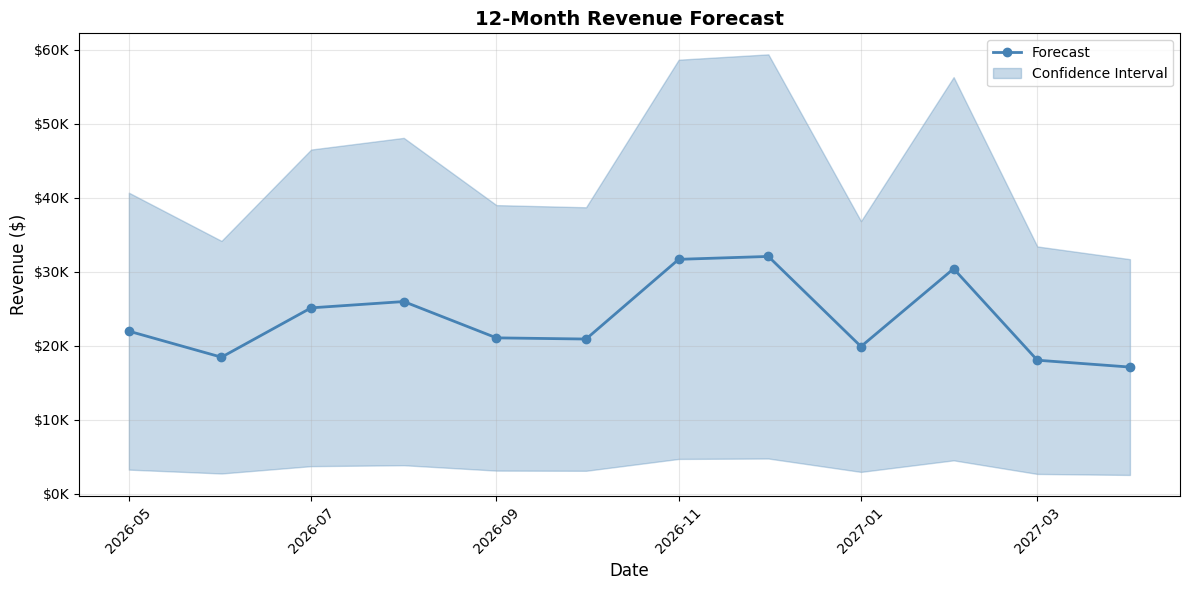


Forecast plot saved to forecast_plot.png


<Figure size 640x480 with 0 Axes>

In [6]:
# Plot forecast
if 'forecast_df' in locals() and not forecast_df.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot forecast
    ax.plot(forecast_df['date'], forecast_df['forecast'], 
            marker='o', linewidth=2, label='Forecast', color='steelblue')
    
    # Plot confidence intervals
    ax.fill_between(forecast_df['date'], forecast_df['lower'], forecast_df['upper'],
                    alpha=0.3, color='steelblue', label='Confidence Interval')
    
    # Formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Revenue ($)', fontsize=12)
    ax.set_title('12-Month Revenue Forecast', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Format y-axis as currency
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()
    
    # Save plot
    plt.savefig('forecast_plot.png', dpi=300, bbox_inches='tight')
    print("\nForecast plot saved to forecast_plot.png")
else:
    print("No forecast data available for plotting")


## 6. Compare Historical vs Forecast


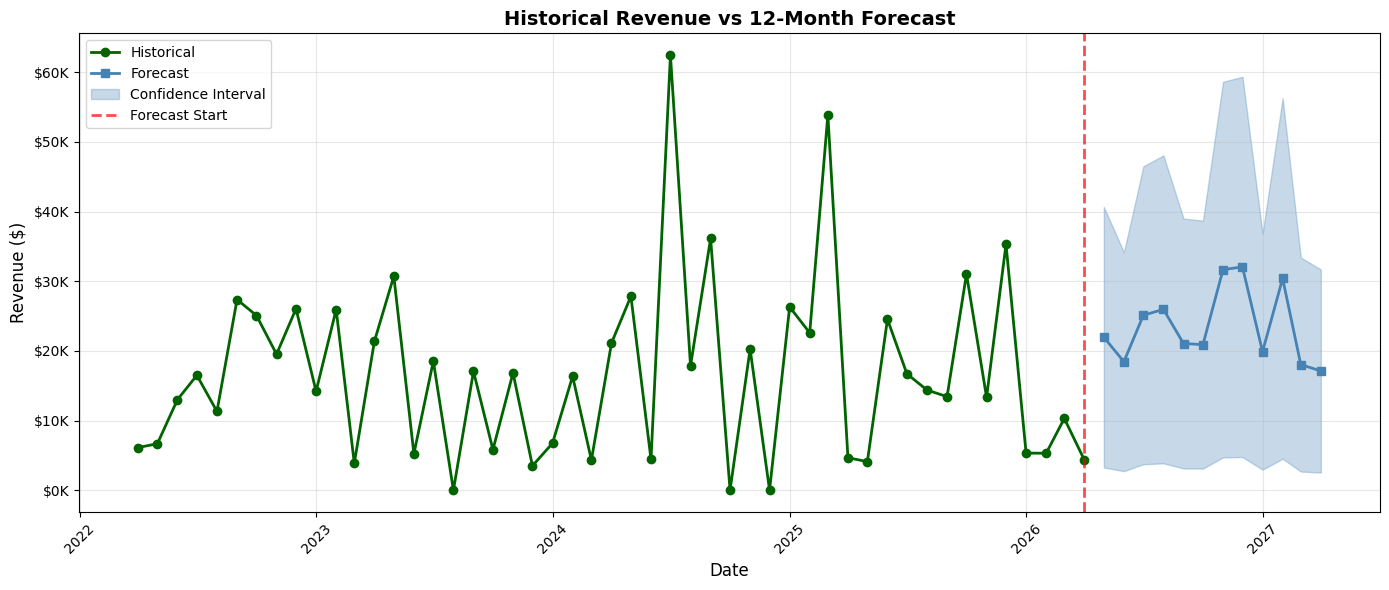


Comparison plot displayed


In [7]:
# Compare historical revenue with forecast
if 'forecast_df' in locals() and 'pipeline' in locals():
    # Get historical monthly revenue
    historical = pipeline.monthly_revenue.copy()
    
    # Combine historical and forecast
    historical['type'] = 'Historical'
    forecast_df['type'] = 'Forecast'
    
    combined = pd.concat([
        historical[['date', 'revenue', 'type']].rename(columns={'revenue': 'value'}),
        forecast_df[['date', 'forecast', 'type']].rename(columns={'forecast': 'value'})
    ])
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Historical
    hist_data = combined[combined['type'] == 'Historical']
    ax.plot(hist_data['date'], hist_data['value'], 
            marker='o', linewidth=2, label='Historical', color='darkgreen')
    
    # Forecast
    forecast_data = combined[combined['type'] == 'Forecast']
    ax.plot(forecast_data['date'], forecast_data['value'], 
            marker='s', linewidth=2, label='Forecast', color='steelblue')
    
    # Confidence intervals
    ax.fill_between(forecast_df['date'], forecast_df['lower'], forecast_df['upper'],
                    alpha=0.3, color='steelblue', label='Confidence Interval')
    
    # Add vertical line separating historical and forecast
    if not historical.empty:
        last_historical_date = historical['date'].max()
        ax.axvline(x=last_historical_date, color='red', linestyle='--', 
                  linewidth=2, label='Forecast Start', alpha=0.7)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Revenue ($)', fontsize=12)
    ax.set_title('Historical Revenue vs 12-Month Forecast', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\nComparison plot displayed")


## 5. Model Validation: Backtesting on Year 4

This section validates the model by:
1. Generating 4 years of historical data
2. Training on years 1-3
3. Forecasting year 4
4. Comparing predictions vs actual year 4 data


In [ ]:
# Model Validation: Backtesting on Year 4
# ===========================================

print("="*70)
print("MODEL VALIDATION: BACKTESTING")
print("="*70)

# Step 1: Generate 4 years of data
# Start date: 4 years ago, end date: today
from datetime import datetime, timedelta
import random

validation_start_date = (datetime.now() - timedelta(days=365*4)).strftime('%Y-%m-%d')
validation_end_date = datetime.now().strftime('%Y-%m-%d')

print(f"\n1. Generating 4 years of data...")
print(f"   Date range: {validation_start_date} to {validation_end_date}")

# Generate data with more records for 4 years (800 records)
validation_data = generate_test_data(
    n_records=800, 
    start_date=validation_start_date, 
    end_date=validation_end_date, 
    active_lead_pct=0.15  # Fewer active leads for historical validation
)

# Convert dates for filtering
validation_data['inquiry_date_dt'] = pd.to_datetime(validation_data['inquiry_date'])
validation_data['trip_date_dt'] = pd.to_datetime(validation_data['trip_date'], errors='coerce')

# Step 2: Split into training (years 1-3) and validation (year 4)
cutoff_date = datetime.now() - timedelta(days=365)  # 1 year ago = start of year 4

# Training data: completed trips in years 1-3
training_data = validation_data[
    (validation_data['current_stage'] == 'completed') &
    (validation_data['trip_date_dt'].notna()) &
    (validation_data['trip_date_dt'] < cutoff_date)
].copy()

# Validation data: completed trips in year 4 (actuals)
validation_actuals = validation_data[
    (validation_data['current_stage'] == 'completed') &
    (validation_data['trip_date_dt'].notna()) &
    (validation_data['trip_date_dt'] >= cutoff_date)
].copy()

# For training, we need ALL data up to cutoff_date (including active leads at that time)
# But mark completed trips after cutoff as "completed" for training context
training_full = validation_data[validation_data['inquiry_date_dt'] < cutoff_date].copy()

# For validation forecast, use data up to cutoff_date (as if cutoff_date is "today")
forecast_reference_data = validation_data[validation_data['inquiry_date_dt'] < cutoff_date].copy()

print(f"\n2. Data Split:")
print(f"   Training period: {validation_start_date} to {cutoff_date.strftime('%Y-%m-%d')}")
print(f"   Validation period: {cutoff_date.strftime('%Y-%m-%d')} to {validation_end_date}")
print(f"   Training completed trips: {len(training_data)}")
print(f"   Validation actual trips: {len(validation_actuals)}")

# Save training data to temporary CSV (in data directory)
import os
data_dir = '../data'
os.makedirs(data_dir, exist_ok=True)
training_csv = os.path.join(data_dir, 'validation_training_data.csv')
training_full.to_csv(training_csv, index=False)
print(f"\n   Saved training data to: {training_csv}")

# Step 3: Prepare actuals for year 4 (monthly revenue)
if not validation_actuals.empty:
    validation_actuals['month'] = validation_actuals['trip_date_dt'].dt.to_period('M')
    actuals_monthly = validation_actuals.groupby('month').agg({
        'trip_price': 'sum'
    }).reset_index()
    actuals_monthly.columns = ['date', 'actual_revenue']
    actuals_monthly['date'] = actuals_monthly['date'].dt.to_timestamp()
    
    # Fill missing months with 0
    date_range = pd.date_range(
        start=actuals_monthly['date'].min(),
        end=actuals_monthly['date'].max(),
        freq='MS'
    )
    actuals_monthly = actuals_monthly.set_index('date').reindex(date_range).reset_index()
    actuals_monthly.columns = ['date', 'actual_revenue']
    actuals_monthly['actual_revenue'] = actuals_monthly['actual_revenue'].fillna(0)
    
    print(f"\n   Year 4 actual revenue: ${actuals_monthly['actual_revenue'].sum():,.0f}")
    print(f"   Year 4 monthly average: ${actuals_monthly['actual_revenue'].mean():,.0f}")
else:
    print(f"\n   ⚠ No validation actuals found - check date filtering")
    actuals_monthly = pd.DataFrame(columns=['date', 'actual_revenue'])


MODEL VALIDATION: BACKTESTING

1. Generating 4 years of data...
   Date range: 2021-11-21 to 2025-11-20

2. Data Split:
   Training period: 2021-11-21 to 2024-11-20
   Validation period: 2024-11-20 to 2025-11-20
   Training completed trips: 175
   Validation actual trips: 97

   Saved training data to: validation_training_data.csv

   Year 4 actual revenue: $546,032
   Year 4 monthly average: $32,120


In [9]:
# Step 3: Train models on years 1-3
print("\n3. Training models on years 1-3...")
print("="*70)

# Create a fresh pipeline instance for validation
validation_pipeline = EnsemblePipeline(model_dir="model/artifacts_validation", min_years=1.0)

try:
    training_metadata = validation_pipeline.train(training_csv)
    print("\n✓ Training completed successfully!")
except Exception as e:
    print(f"\n✗ Training error: {e}")
    import traceback
    traceback.print_exc()
    raise


14:50:25 - cmdstanpy - INFO - Chain [1] start processing



3. Training models on years 1-3...
Saving models to: ./model/artifacts_validation
ENSEMBLE PIPELINE - TRAINING

Loading data from validation_training_data.csv...

Data Summary:
  Total records: 508
  Completed trips: 202
  Total revenue: $1,116,924
  Date range: 3.22 years
  Conversion rate: 39.8%

Preparing monthly revenue time series...
  Monthly data points: 40
TRAINING ENSEMBLE MODELS
Training Prophet model...


14:50:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:50:25 - cmdstanpy - INFO - Chain [1] start processing
14:50:25 - cmdstanpy - INFO - Chain [1] done processing
14:50:25 - cmdstanpy - INFO - Chain [1] start processing
14:50:25 - cmdstanpy - INFO - Chain [1] done processing
14:50:25 - cmdstanpy - INFO - Chain [1] start processing
14:50:26 - cmdstanpy - INFO - Chain [1] done processing
14:50:26 - cmdstanpy - INFO - Chain [1] start processing
14:50:26 - cmdstanpy - INFO - Chain [1] done processing
14:50:26 - cmdstanpy - INFO - Chain [1] start processing
14:50:26 - cmdstanpy - INFO - Chain [1] done processing
14:50:26 - cmdstanpy - INFO - Chain [1] start processing
14:50:26 - cmdstanpy - INFO - Chain [1] done processing
14:50:26 - cmdstanpy - INFO - Chain [1] start processing
14:50:27 - cmdstanpy - INFO - Chain [1] done processing
14:50:27 - cmdstanpy - INFO - Chain [1] start pro


PROPHET MODEL PERFORMANCE METRICS (Cross-Validation)
  MAPE (Mean Absolute % Error): 3.32%
  MAE  (Mean Absolute Error):    $67,485
  RMSE (Root Mean Squared Error): $101,003
  MSE  (Mean Squared Error):     $15,728,231,314

Prophet model trained and saved to ./model/artifacts_validation/prophet_model.pkl
Training XGBoost model...
Note: Using XGBoost fit() without early_stopping_rounds (version compatibility)

XGBOOST MODEL PERFORMANCE METRICS

Test Set Performance:
  Accuracy:  0.588 (58.8%)
  ROC-AUC:   0.591
  Precision: 0.485
  Recall:    0.390
  F1-Score:  0.432

Training Set Performance (for comparison):
  Accuracy:  0.771 (77.1%)
  ROC-AUC:   0.867

Confusion Matrix:
  True Negatives:  44
  False Positives: 17
  False Negatives: 25
  True Positives:  16

XGBoost model saved to ./model/artifacts_validation/xgboost_model.json

TRAINING COMPLETE

TRAINING METRICS SUMMARY

Prophet Model:
  Status: ✓ Trained
  Training samples: 40
  MAPE: 3.32%
  MAE:  $67,485
  RMSE: $101,003

XGBo

In [ ]:
# Step 4: Generate forecast for year 4
print("\n4. Generating forecast for year 4...")
print("="*70)

# Use cutoff_date as the forecast reference date (as if it's "today")
import os
data_dir = '../data'
os.makedirs(data_dir, exist_ok=True)
forecast_reference_csv = os.path.join(data_dir, 'validation_forecast_data.csv')
forecast_reference_data.to_csv(forecast_reference_csv, index=False)

try:
    # Generate forecast using data up to cutoff_date
    forecast_df = validation_pipeline.forecast(
        csv_path=forecast_reference_csv,
        forecast_date=cutoff_date.strftime('%Y-%m-%d')
    )
    
    print(f"\n✓ Forecast generated: {len(forecast_df)} months")
    print(f"   Forecast total: ${forecast_df['forecast'].sum():,.0f}")
    
except Exception as e:
    print(f"\n✗ Forecast error: {e}")
    import traceback
    traceback.print_exc()
    raise



4. Generating forecast for year 4...
ENSEMBLE PIPELINE - INFERENCE

Loading trained models...
Loading models from: ./model/artifacts_validation
   Files found: ['xgboost_model.json', 'prophet_model.pkl', 'label_encoders.pkl', 'training_metadata.pkl', 'feature_names.pkl']
✓ Loaded Prophet model
✓ Loaded XGBoost model

Analyzing active pipeline...
  Active leads: 27
  Pipeline value: $155,217
  By stage:
    final_payment: 27.0 leads, $155,217
GENERATING 12-MONTH FORECAST
Forecast start date: 2025-06-01
Historical revenue stats: mean=$27,923, min=$3,521, max=$74,141
Recent average (last 12 months): $25,621 ± $11,559
✓ Prophet forecast: $287,194 total (avg: $23,933/month)
✓ XGBoost forecast: $84,058 total
   Pipeline: 27 leads, Avg conversion prob: 53.3%
✓ Pipeline forecast: $152,113 total (distributed: $12,676/month)

Ensemble forecast: $201,893 total
  Average monthly: $16,824
  Min monthly: $5,862
  Max monthly: $29,978

✓ Forecast generated: 12 months
   Forecast total: $201,893


In [11]:
# Step 5: Compare predictions vs actuals
print("\n5. Comparing Predictions vs Actuals")
print("="*70)

if not actuals_monthly.empty and not forecast_df.empty:
    # Merge forecast and actuals on date
    comparison = forecast_df[['date', 'forecast', 'lower', 'upper']].copy()
    comparison['date'] = pd.to_datetime(comparison['date'])
    actuals_monthly['date'] = pd.to_datetime(actuals_monthly['date'])
    
    # Merge on date (using month start)
    comparison = comparison.merge(
        actuals_monthly[['date', 'actual_revenue']],
        on='date',
        how='left'
    )
    comparison['actual_revenue'] = comparison['actual_revenue'].fillna(0)
    
    # Calculate metrics
    comparison['error'] = comparison['forecast'] - comparison['actual_revenue']
    comparison['abs_error'] = comparison['error'].abs()
    comparison['pct_error'] = (comparison['error'] / comparison['actual_revenue'].replace(0, np.nan)) * 100
    
    # Filter to only months with actuals (remove future months)
    comparison = comparison[comparison['actual_revenue'] > 0].copy()
    
    if len(comparison) > 0:
        # Calculate metrics
        mae = comparison['abs_error'].mean()
        rmse = np.sqrt((comparison['error']**2).mean())
        mape = comparison['pct_error'].abs().mean()
        
        # Calculate total revenue comparison
        forecast_total = comparison['forecast'].sum()
        actual_total = comparison['actual_revenue'].sum()
        total_error_pct = ((forecast_total - actual_total) / actual_total) * 100 if actual_total > 0 else 0
        
        print(f"\nValidation Metrics:")
        print(f"  Months compared: {len(comparison)}")
        print(f"  MAE (Mean Absolute Error): ${mae:,.0f}")
        print(f"  RMSE (Root Mean Squared Error): ${rmse:,.0f}")
        print(f"  MAPE (Mean Absolute % Error): {mape:.1f}%")
        print(f"\n  Total Revenue:")
        print(f"    Forecasted: ${forecast_total:,.0f}")
        print(f"    Actual: ${actual_total:,.0f}")
        print(f"    Error: ${forecast_total - actual_total:,.0f} ({total_error_pct:+.1f}%)")
        
        # Display comparison table
        print(f"\nMonthly Comparison:")
        print("="*100)
        comparison_display = comparison[['date', 'forecast', 'actual_revenue', 'error', 'pct_error']].copy()
        comparison_display['date'] = comparison_display['date'].dt.strftime('%Y-%m')
        comparison_display.columns = ['Month', 'Forecast', 'Actual', 'Error', '% Error']
        comparison_display['Forecast'] = comparison_display['Forecast'].apply(lambda x: f"${x:,.0f}")
        comparison_display['Actual'] = comparison_display['Actual'].apply(lambda x: f"${x:,.0f}")
        comparison_display['Error'] = comparison_display['Error'].apply(lambda x: f"${x:+,.0f}")
        comparison_display['% Error'] = comparison_display['% Error'].apply(lambda x: f"{x:+.1f}%")
        print(comparison_display.to_string(index=False))
        
    else:
        print("⚠ No overlapping months between forecast and actuals")
        print("   This might mean the forecast period doesn't match validation period")
        
else:
    print("⚠ Cannot compare - missing forecast or actuals data")
    if actuals_monthly.empty:
        print("   No actuals data found")
    if forecast_df.empty:
        print("   No forecast data generated")



5. Comparing Predictions vs Actuals

Validation Metrics:
  Months compared: 11
  MAE (Mean Absolute Error): $12,829
  RMSE (Root Mean Squared Error): $16,379
  MAPE (Mean Absolute % Error): 39.3%

  Total Revenue:
    Forecasted: $196,031
    Actual: $329,949
    Error: $-133,918 (-40.6%)

Monthly Comparison:
  Month Forecast  Actual    Error % Error
2025-06  $11,664 $45,369 $-33,705  -74.3%
2025-07  $15,330 $43,872 $-28,542  -65.1%
2025-08  $23,912 $31,885  $-7,973  -25.0%
2025-09  $29,978 $31,180  $-1,202   -3.9%
2025-10  $15,300 $33,678 $-18,379  -54.6%
2025-11  $16,211 $27,631 $-11,420  -41.3%
2025-12  $25,865 $37,060 $-11,195  -30.2%
2026-01  $25,950 $23,973  $+1,977   +8.2%
2026-02  $14,988 $13,363  $+1,625  +12.2%
2026-03   $9,918 $19,313  $-9,395  -48.6%
2026-04   $6,914 $22,625 $-15,710  -69.4%



6. Creating comparison visualization...


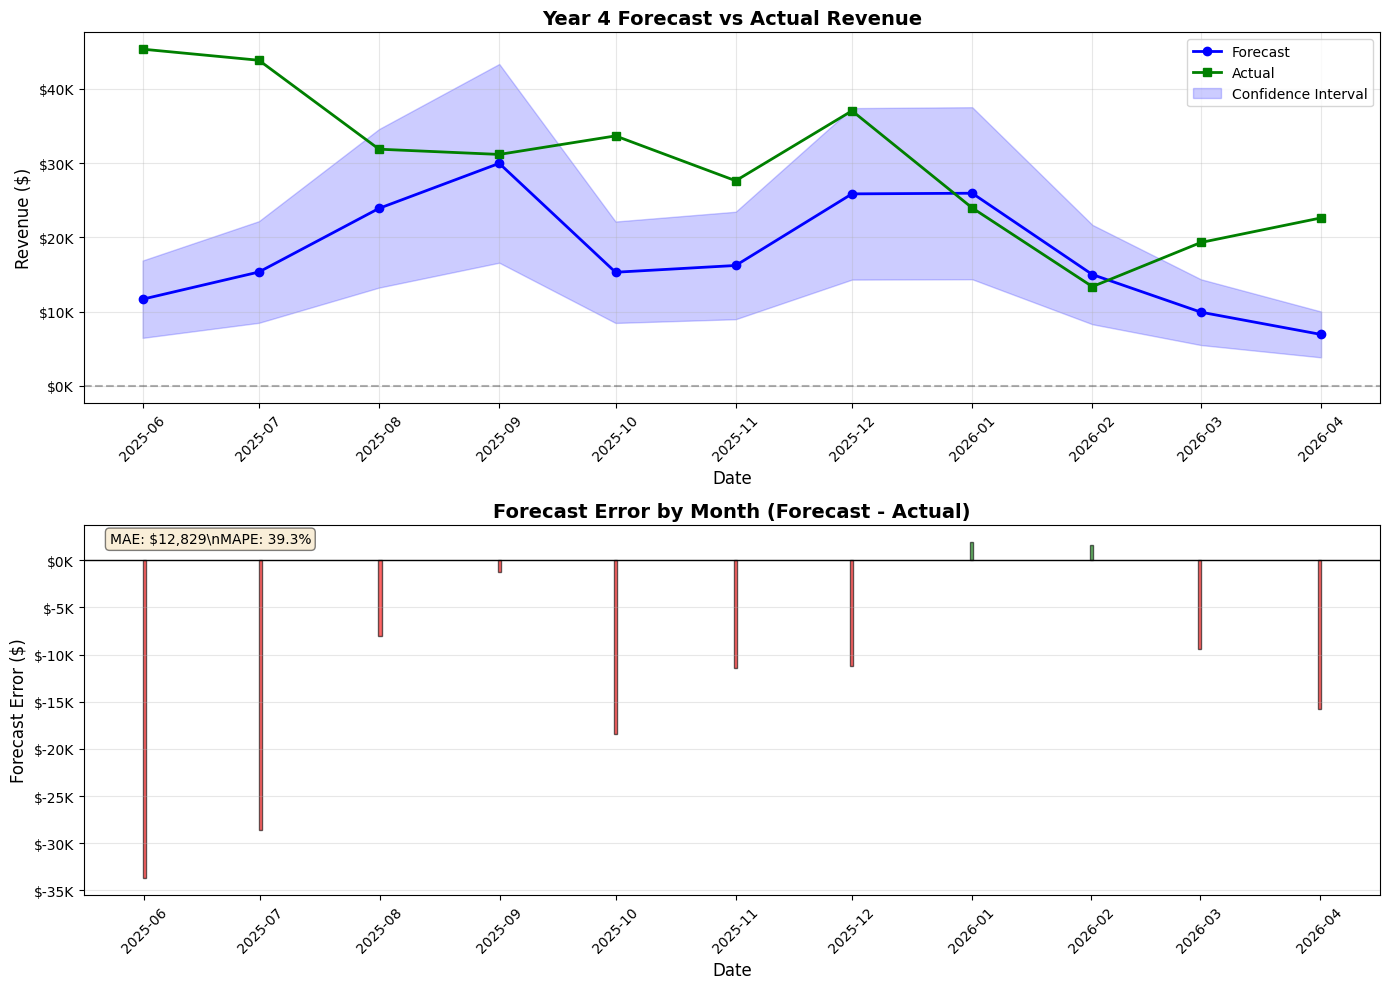

✓ Visualization created


In [12]:
# Step 6: Visualization
print("\n6. Creating comparison visualization...")
print("="*70)

if 'comparison' in locals() and len(comparison) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Forecast vs Actual
    ax1 = axes[0]
    ax1.plot(comparison['date'], comparison['forecast'], 'b-o', label='Forecast', linewidth=2, markersize=6)
    ax1.plot(comparison['date'], comparison['actual_revenue'], 'g-s', label='Actual', linewidth=2, markersize=6)
    ax1.fill_between(comparison['date'], comparison['lower'], comparison['upper'], 
                     alpha=0.2, color='blue', label='Confidence Interval')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Revenue ($)', fontsize=12)
    ax1.set_title('Year 4 Forecast vs Actual Revenue', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Format y-axis as currency
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # Plot 2: Error analysis
    ax2 = axes[1]
    colors = ['red' if x < 0 else 'green' for x in comparison['error']]
    ax2.bar(comparison['date'], comparison['error'], color=colors, alpha=0.6, edgecolor='black')
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Forecast Error ($)', fontsize=12)
    ax2.set_title('Forecast Error by Month (Forecast - Actual)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=45)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    # Add text annotations for summary metrics
    mae = comparison['abs_error'].mean()
    mape = comparison['pct_error'].abs().mean()
    ax2.text(0.02, 0.98, f'MAE: ${mae:,.0f}\\nMAPE: {mape:.1f}%', 
            transform=ax2.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization created")
else:
    print("⚠ Cannot create visualization - missing comparison data")


In [13]:
# Calculate summary statistics
if 'forecast_df' in locals() and not forecast_df.empty:
    print("Forecast Summary Statistics:")
    print("="*70)
    
    # Monthly statistics
    print(f"\nMonthly Forecast:")
    print(f"  Mean: ${forecast_df['forecast'].mean():,.0f}")
    print(f"  Median: ${forecast_df['forecast'].median():,.0f}")
    print(f"  Min: ${forecast_df['forecast'].min():,.0f}")
    print(f"  Max: ${forecast_df['forecast'].max():,.0f}")
    print(f"  Std Dev: ${forecast_df['forecast'].std():,.0f}")
    
    # Quarterly aggregation
    forecast_df['quarter'] = forecast_df['date'].dt.quarter
    forecast_df['year'] = forecast_df['date'].dt.year
    forecast_df['quarter_label'] = forecast_df['year'].astype(str) + ' Q' + forecast_df['quarter'].astype(str)
    
    quarterly = forecast_df.groupby('quarter_label')['forecast'].sum()
    
    print(f"\nQuarterly Forecast:")
    for quarter, revenue in quarterly.items():
        print(f"  {quarter}: ${revenue:,.0f}")
    
    # Total forecast
    print(f"\nTotal 12-Month Forecast: ${forecast_df['forecast'].sum():,.0f}")
    
    # Growth rate (if we have historical data)
    if 'pipeline' in locals() and pipeline.monthly_revenue is not None:
        hist = pipeline.monthly_revenue
        if len(hist) >= 12:
            last_12_months_hist = hist['revenue'].tail(12).sum()
            forecast_total = forecast_df['forecast'].sum()
            growth_rate = ((forecast_total - last_12_months_hist) / last_12_months_hist) * 100
            print(f"\nGrowth Rate vs Last 12 Months: {growth_rate:+.1f}%")
else:
    print("No forecast data available")


Forecast Summary Statistics:

Monthly Forecast:
  Mean: $16,824
  Median: $15,315
  Min: $5,862
  Max: $29,978
  Std Dev: $7,916

Quarterly Forecast:
  2025 Q2: $11,664
  2025 Q3: $69,220
  2025 Q4: $57,376
  2026 Q1: $50,856
  2026 Q2: $12,776

Total 12-Month Forecast: $201,893

Growth Rate vs Last 12 Months: +13.4%
